In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
import time

实现步骤：
1.对多曝光图像序列{xk}进行双线性下采样，获得降采样的图像序列{Xkl}以减少数据的运算量
2.CAN网络以降采样的图像序列为输入，输出低分辨率的权重图 。
3.然后，以{Xkl}为引导图，对权重图{Wkl}进行引导滤波
4.联合双线性插值上采样，获得全分辨率（与Xk分辨率相同）的权重图{Wk}
5.最后融合图像Y根据多曝光图像序列的加权求和获得
6.评价机制

所以神经网络训练的作用主要是获得权重图，是对权重函数和加权融合函数的修改更新，本质上和debevec算法是一样的。

需要学习的是：
1.怎么进行双线性下采样
2.CAN网络结构和神经网络训练相关（工作量最大）
3.怎么进行引导滤波
4.学习双线性插值上采样
5.加权融合算法：Hadamard乘积
6.评价机制

CAN网络结构相关：
1.采用空洞卷积方式，在不牺牲图像空间分辨率的情况下，获得更大的感受野。
2.卷积层：卷积核大小为3*3，卷积核数目为24
3.线性整流激活函数（LRelu）
4.自适应归一化操作->避免梯度消失；加快学习收敛速度
5.最后一层卷积作用于生成和输入图像大小一致的权重图，卷积核大小为1*1，且不使用自适应归一化操作
6.此外{Xkl}以权重共享的方式输入CAN网络->保证了本网络可以融合任意数量的不同曝光度图像

需要学习的是：
1.CAN网络实现
2.空洞卷积（需要学习，也可以考虑换成标准卷积）
3.自适应归一化操作
4.权重共享方式
5.损失函数设计（比较难，如果这个很难，不是很会实现的话，可以考虑换成其他的损失函数，例如常用的最小二乘损失之类的，就是效果会略差，假装是咱们的创新点，也不用考虑参数τc的问题了）
6.自学习（用预训练好的模型参数进行参数微调，减弱或消除光晕现象）

自学习过程（可能要学一下非监督学习的相关知识，但是代码应该和训练代码差不多）：
1.基于前面提到的网络结构和损失，采用多曝光图像(多于两幅)对网络进行训练，获得最佳的权重参数
2.面向两幅极度曝光图像的融合，将学习到的最佳权重参数作为网络权重的初始值，不改变网络的结构和损失函数，基于当前两幅极度曝光的测试图像，对网络进行再学习和优化，非监督地自学习得到适用于当前融合图像的最佳参数。

数据集：https://github.com/hangxiaotian/Perceptual-Multi-exposure-Image-Fusion

自学习应该还蛮必要的，不然会出现过曝现象
然后最后还可以加以分析，就像论文最后那部分参数τc对极度曝光情况的影响
作者也提出了优化的方向，就是怎么获得最优的参数τc

难点：
1.学习自适应归一化（论文）
2.写损失函数
3.引导滤波（论文）
4.加权融合（灰度和彩色）
5.评价机制（待定）

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd ./drive/MyDrive/FLNotebooks
# !ls

In [4]:
import re
def sort_key(s):
    #获取图片名称
    tail = s.split('\\')[-1]
    # 匹配开头数字序号
    c = re.findall('\d+', tail)[0]
    return int(c)

def strsort(alist):
    alist.sort(key=sort_key)
    return alist

In [5]:
from torch.utils.data import DataLoader, Dataset
import torch

# 使用dataloader读取数据
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

Images array shape: (378, 3, 356, 536)
Images array dtype: float32


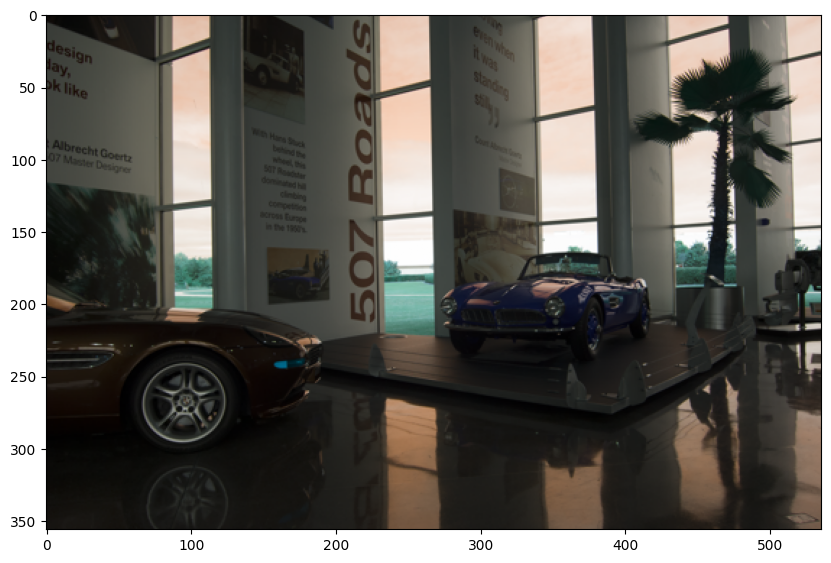

In [6]:
# 对多曝光图像序列{xk}进行双线性下采样，获得降采样的图像序列{Xkl}以减少数据的运算量
import numpy as np #导入numpy模块
from PIL import Image #入PIL模块用于读取图片，也可使用opencv
import os
import torch.nn.functional as F
import torch
import cv2
import pylab
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

images=[]
path = './dataset/Dataset/dataset1/HDRPS_downsampling_8/'	#数据集路径,这个数据集中每个组有9张照片
#循环遍历数据集下的所有子文件(如果连子目录也读取)
domList = os.listdir(path)
domList = sorted(domList)
#domList.sort(key=lambda x: int(x.replace("_MDF","").split('.')[0]))#按照数字进行排序后按顺序读取文件夹下的图片
for name_file in domList:
    #遍历子文件下的所有图片文件
    imgList = os.listdir(path+name_file)
    imgList=sorted(imgList)#按照数字进行排序后按顺序读取文件夹下的图片,9个一组
    for img_file in imgList:
      # print(img_file)	#打印当前读取的图片名
      #以下代码根据需要更改
      img = cv2.imread(path+name_file+'/'+img_file)
      if img.shape[0] > img.shape[1]:
          img = np.transpose(img, (1, 0, 2))
      # 将图像数据类型转换为 float32
      img = img.astype(np.float32) / 255.0
      images.append(img)
images_array = np.array(images, dtype=np.float32) #转为float32型的数组

m = images_array.shape[0]
h, w, c = images_array[0].shape
image_array_0 = np.zeros((m, c, h, w), dtype=np.float32)
for i, image in enumerate(images_array):
  if image.shape[0] > images_array.shape[1]:
    image_array_0[i] = np.transpose(image, (2, 1, 0))
  else:
    # print(image.shape)
    image_array_0[i] = np.transpose(image, (2, 0, 1))

# 打印转换后的数组形状和数据类型
print(f'Images array shape: {image_array_0.shape}')
print(f'Images array dtype: {image_array_0.dtype}')
#imgs = strsort(images)
# plt.subplot(1, 2, 1)

# 创建数据集
dataset = CustomDataset(image_array_0)

# 创建 DataLoader
dataloader = DataLoader(dataset, batch_size=9, shuffle=True, num_workers=0) #num_workers可能会需要改一下

# 获取一个批次的数据
data_iter = iter(dataloader)
image = next(data_iter)

plt.figure(figsize=(10, 20))
plt.imshow(np.transpose(image_array_0[4], (1, 2, 0)))

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
class BilinearDownsampleLayer(nn.Module):
    def __init__(self, scale_factor):
        super(BilinearDownsampleLayer, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode='bilinear', align_corners=True)

In [9]:
import torch

def _diff_x(src, r):
    cum_src = src.cumsum(-2)

    left = cum_src[..., r:2*r + 1, :]
    middle = cum_src[..., 2*r + 1:, :] - cum_src[..., :-2*r - 1, :]
    right = cum_src[..., -1:, :] - cum_src[..., -2*r - 1:-r - 1, :]

    output = torch.cat([left, middle, right], -2)

    return output

def _diff_y(src, r):
    cum_src = src.cumsum(-1)

    left = cum_src[..., r:2*r + 1]
    middle = cum_src[..., 2*r + 1:] - cum_src[..., :-2*r - 1]
    right = cum_src[..., -1:] - cum_src[..., -2*r - 1:-r - 1]

    output = torch.cat([left, middle, right], -1)

    return output

def boxfilter2d(src, radius):
    return _diff_y(_diff_x(src, radius), radius)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GuidedFilter2d(nn.Module):
    def __init__(self, radius: int, eps: float):
        super().__init__()
        self.r = radius
        self.eps = eps

    def forward(self, x, guide):
        if guide.shape[1] == 3:
            return guidedfilter2d_color(guide, x, self.r, self.eps)
        elif guide.shape[1] == 1:
            return guidedfilter2d_gray(guide, x, self.r, self.eps)
        else:
            raise NotImplementedError

class FastGuidedFilter2d(GuidedFilter2d):
    """Fast guided filter"""
    def __init__(self, radius: int, eps: float, s: int):
        super().__init__(radius, eps)
        self.s = s

    def forward(self, x, guide):
        # print(guide.shape[1])
        if guide.shape[1] == 3:
            return guidedfilter2d_color(guide, x, self.r, self.eps, self.s)
        elif guide.shape[1] == 1:
            return guidedfilter2d_gray(guide, x, self.r, self.eps, self.s)
        else:
            raise NotImplementedError

def guidedfilter2d_color(guide, src, radius, eps, scale=None):
    """guided filter for a color guide image

    Parameters
    -----
    guide: (B, 3, H, W)-dim torch.Tensor
        guide image
    src: (B, C, H, W)-dim torch.Tensor
        filtering image
    radius: int
        filter radius
    eps: float
        regularization coefficient
    """
    assert guide.shape[1] == 3
    if src.ndim == 3:
        src = src[:, None]
    scale_height = guide.shape[2] / src.shape[2]
    scale_width = guide.shape[3] / src.shape[3]
    if scale is not None:
        guide_sub = guide.clone()
        src = F.interpolate(src, scale_factor=(scale_height, scale_width), mode="nearest")
        # guide = F.interpolate(guide, scale_factor=scale, mode="nearest")
        radius = radius // scale

    guide_r, guide_g, guide_b = torch.chunk(guide, 3, 1) # b x 1 x H x W
    ones = torch.ones_like(guide_r)
    N = boxfilter2d(ones, radius)

    mean_I = boxfilter2d(guide, radius) / N # b x 3 x H x W
    mean_I_r, mean_I_g, mean_I_b = torch.chunk(mean_I, 3, 1) # b x 1 x H x W

    mean_p = boxfilter2d(src, radius) / N # b x C x H x W

    mean_Ip_r = boxfilter2d(guide_r * src, radius) / N # b x C x H x W
    mean_Ip_g = boxfilter2d(guide_g * src, radius) / N # b x C x H x W
    mean_Ip_b = boxfilter2d(guide_b * src, radius) / N # b x C x H x W

    cov_Ip_r = mean_Ip_r - mean_I_r * mean_p # b x C x H x W
    cov_Ip_g = mean_Ip_g - mean_I_g * mean_p # b x C x H x W
    cov_Ip_b = mean_Ip_b - mean_I_b * mean_p # b x C x H x W

    var_I_rr = boxfilter2d(guide_r * guide_r, radius) / N - mean_I_r * mean_I_r + eps # b x 1 x H x W
    var_I_rg = boxfilter2d(guide_r * guide_g, radius) / N - mean_I_r * mean_I_g # b x 1 x H x W
    var_I_rb = boxfilter2d(guide_r * guide_b, radius) / N - mean_I_r * mean_I_b # b x 1 x H x W
    var_I_gg = boxfilter2d(guide_g * guide_g, radius) / N - mean_I_g * mean_I_g + eps # b x 1 x H x W
    var_I_gb = boxfilter2d(guide_g * guide_b, radius) / N - mean_I_g * mean_I_b # b x 1 x H x W
    var_I_bb = boxfilter2d(guide_b * guide_b, radius) / N - mean_I_b * mean_I_b + eps # b x 1 x H x W

    # determinant
    cov_det = var_I_rr * var_I_gg * var_I_bb \
        + var_I_rg * var_I_gb * var_I_rb \
            + var_I_rb * var_I_rg * var_I_gb \
                - var_I_rb * var_I_gg * var_I_rb \
                    - var_I_rg * var_I_rg * var_I_bb \
                        - var_I_rr * var_I_gb * var_I_gb # b x 1 x H x W

    # inverse
    inv_var_I_rr = (var_I_gg * var_I_bb - var_I_gb * var_I_gb) / cov_det # b x 1 x H x W
    inv_var_I_rg = - (var_I_rg * var_I_bb - var_I_rb * var_I_gb) / cov_det # b x 1 x H x W
    inv_var_I_rb = (var_I_rg * var_I_gb - var_I_rb * var_I_gg) / cov_det # b x 1 x H x W
    inv_var_I_gg = (var_I_rr * var_I_bb - var_I_rb * var_I_rb) / cov_det # b x 1 x H x W
    inv_var_I_gb = - (var_I_rr * var_I_gb - var_I_rb * var_I_rg) / cov_det # b x 1 x H x W
    inv_var_I_bb = (var_I_rr * var_I_gg - var_I_rg * var_I_rg) / cov_det # b x 1 x H x W

    inv_sigma = torch.stack([
        torch.stack([inv_var_I_rr, inv_var_I_rg, inv_var_I_rb], 1),
        torch.stack([inv_var_I_rg, inv_var_I_gg, inv_var_I_gb], 1),
        torch.stack([inv_var_I_rb, inv_var_I_gb, inv_var_I_bb], 1)
    ], 1).squeeze(-3) # b x 3 x 3 x H x W

    cov_Ip = torch.stack([cov_Ip_r, cov_Ip_g, cov_Ip_b], 1) # b x 3 x C x H x W

    a = torch.einsum("bichw,bijhw->bjchw", (cov_Ip, inv_sigma))
    b = mean_p - a[:, 0] * mean_I_r - a[:, 1] * mean_I_g - a[:, 2] * mean_I_b # b x C x H x W

    mean_a = torch.stack([boxfilter2d(a[:, i], radius) / N for i in range(3)], 1)
    mean_b = boxfilter2d(b, radius) / N

    if scale is not None:
        guide = guide_sub
        mean_a = torch.stack([F.interpolate(mean_a[:, i], guide.shape[-2:], mode='bilinear') for i in range(3)], 1)
        mean_b = F.interpolate(mean_b, guide.shape[-2:], mode='bilinear')

    q = torch.einsum("bichw,bihw->bchw", (mean_a, guide)) + mean_b

    return q

def guidedfilter2d_gray(guide, src, radius, eps, scale=None):
    """guided filter for a gray scale guide image

    Parameters
    -----
    guide: (B, 1, H, W)-dim torch.Tensor
        guide image
    src: (B, C, H, W)-dim torch.Tensor
        filtering image
    radius: int
        filter radius
    eps: float
        regularization coefficient
    """
    if guide.ndim == 3:
        guide = guide[:, None]
    if src.ndim == 3:
        src = src[:, None]


    if scale is not None:
        guide_sub = guide.clone()
        src = F.interpolate(src, scale_factor=1./scale, mode="nearest")
        guide = F.interpolate(guide, scale_factor=1./scale, mode="nearest")
        radius = radius // scale

    ones = torch.ones_like(guide)
    N = boxfilter2d(ones, radius)

    mean_I = boxfilter2d(guide, radius) / N
    mean_p = boxfilter2d(src, radius) / N
    mean_Ip = boxfilter2d(guide*src, radius) / N
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = boxfilter2d(guide*guide, radius) / N
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = boxfilter2d(a, radius) / N
    mean_b = boxfilter2d(b, radius) / N

    if scale is not None:
        guide = guide_sub
        mean_a = F.interpolate(mean_a, guide.shape[-2:], mode='bilinear')
        mean_b = F.interpolate(mean_b, guide.shape[-2:], mode='bilinear')

    q = mean_a * guide + mean_b
    return q

In [11]:
import torch
import torch.nn as nn

class MergeLayer(nn.Module):
    def __init__(self):
        super(MergeLayer, self).__init__()

    def forward(self, w, x):
        zero_tensor = torch.zeros_like(x[0], device=device)
        y = torch.zeros_like(x[0], device=device)
        weight_sum = torch.zeros_like(x[0], device=device)
        for i in range(w.shape[0]):
          weight_sum = weight_sum + torch.abs(w[i])
        for i in range(x.shape[0]):
            weighted_output = torch.where(weight_sum != 0, torch.abs(w[i]) / weight_sum, zero_tensor)
            y = y + weighted_output * x[i].unsqueeze(0) / 255.0
        return y

In [12]:
# 定义神经网络
class CANNet(nn.Module):
    def __init__(self):
        super(CANNet,self).__init__()
        self.downsample = BilinearDownsampleLayer(scale_factor=0.5)
        #定义六层卷积层
        self.conv = nn.Sequential(
            # 空洞卷积
            # pytorch封装卷积层
            # 第一层 (W-3)/1+1 （H-3)/1+1
            nn.Conv2d(in_channels = 3,out_channels = 24,kernel_size = 3 , stride = 1,padding=1,dilation=1),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第二层
            nn.Conv2d(in_channels = 24,out_channels = 24,kernel_size = 3 , stride = 1,padding=2,dilation=2),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第三层
            nn.Conv2d(in_channels = 24,out_channels = 24,kernel_size = 3 , stride = 1,padding=2,dilation=2),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第四层
            nn.Conv2d(in_channels = 24,out_channels = 24,kernel_size = 3 , stride = 1,padding=2,dilation=2),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第五层
            nn.Conv2d(in_channels = 24,out_channels = 24,kernel_size = 3 , stride = 1,padding=2,dilation=2),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第六层
            nn.Conv2d(in_channels = 24,out_channels = 24,kernel_size = 3 , stride = 1,padding=2,dilation=2),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第七层
            nn.Conv2d(in_channels = 24,out_channels = 3,kernel_size = 1 , stride = 1,padding=0,dilation=1)
        )
        self.guided_filter = FastGuidedFilter2d(16, 1e-4, 2)
        self.merge_function = MergeLayer()

    def forward(self,x):
        # 下采样
        downsampled = self.downsample(x)
        # 卷积层
        out = self.conv(downsampled)
        # 引导滤波联合上采样
        filtered = self.guided_filter(out, x)
        merge_result = self.merge_function(filtered, x)
        return merge_result

In [13]:
from skimage.metrics import structural_similarity as ssim

# 强度保真约束项
def intensity_fidelity_loss(Y, Xk, tau_c=0.5, Pmax=255):
    K = len(Xk)
    mu_k = [torch.mean(x) for x in Xk]
    weights = [
        ((sum([abs(mu_t - tau_c) for mu_t in mu_k]) - abs(mu_k[k] - tau_c)) /
         ((K - 1) * sum([abs(mu_t - tau_c) for mu_t in mu_k])))
        for k in range(K)
    ]
    I_p = sum([weights[k] * Xk[k] for k in range(K)])
    loss = F.mse_loss(Y, I_p)
    return loss

# 加权的多曝光图像融合结构相似性度量项
def weighted_mef_ssim_loss(Y, Xk, Pmax=255):
    K = len(Xk)
    mu_k = [torch.mean(x) for x in Xk]
    mu_k_sorted = sorted(mu_k)
    d_mu = max([mu_k_sorted[i+1] - mu_k_sorted[i] for i in range(K-1)])
    sigma = 0.2
    xi = 0.1 * Pmax
    gamma = torch.exp(-(d_mu - (K - 1) * xi / (K - 1)) ** 2 / (1.2 * sigma ** 2))

    # MEF-SSIM指标
    def ssim_metric(img1, img2):
        img1 = img1.cpu().detach().numpy().astype(np.float32)
        img2 = img2.cpu().detach().numpy().astype(np.float32)
        return ssim(img1.squeeze(0), img2.squeeze(0), data_range=img1.max() - img1.min(), channel_axis=0)

    ssim_values = [ssim_metric(Y, x) for x in Xk]
    weighted_ssim = gamma * torch.tensor(ssim_values).mean()
    loss = 1 - weighted_ssim
    return loss

# 损失函数
def total_loss(Y, Xk, tau_c=0.5, Pmax=255):
    L_mse = intensity_fidelity_loss(Y, Xk, tau_c, Pmax)
    L_mef_ssim = weighted_mef_ssim_loss(Y, Xk, Pmax)
    return L_mse + L_mef_ssim

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
    
    def forward(self, Y, X):
        loss = total_loss(Y, X)
        return loss

In [14]:
import torch
import torch.nn.functional as F
from math import exp


def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss / (gauss.sum())


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, window_size/6.).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2D_window.expand(1, channel, window_size, window_size).contiguous()) / channel
    return window


def _mef_ssim(X, Ys, window, ws, denom_g, denom_l, C1, C2, is_lum=False, full=False):
    K, C, H, W = list(Ys.size())

    # compute statistics of the reference latent image Y
    muY_seq = F.conv2d(Ys, window, padding=ws // 2).view(K, H, W)
    muY_sq_seq = muY_seq * muY_seq
    sigmaY_sq_seq = F.conv2d(Ys * Ys, window, padding=ws // 2).view(K, H, W) \
                        - muY_sq_seq
    sigmaY_sq, patch_index = torch.max(sigmaY_sq_seq, dim=0)

    # compute statistics of the test image X
    muX = F.conv2d(X, window, padding=ws // 2).view(H, W)
    muX_sq = muX * muX
    sigmaX_sq = F.conv2d(X * X, window, padding=ws // 2).view(H, W) - muX_sq

    # compute correlation term
    sigmaXY = F.conv2d(X.expand_as(Ys) * Ys, window, padding=ws // 2).view(K, H, W) \
                - muX.expand_as(muY_seq) * muY_seq

    # compute quality map
    cs_seq = (2 * sigmaXY + C2) / (sigmaX_sq + sigmaY_sq_seq + C2)
    cs_map = torch.gather(cs_seq.view(K, -1), 0, patch_index.view(1, -1)).view(H, W)
    if is_lum:
        lY = torch.mean(muY_seq.view(K, -1), dim=1)
        lL = torch.exp(-((muY_seq - 0.5) ** 2) / denom_l)
        lG = torch.exp(- ((lY - 0.5) ** 2) / denom_g)[:, None, None].expand_as(lL)
        LY = lG * lL
        muY = torch.sum((LY * muY_seq), dim=0) / torch.sum(LY, dim=0)
        muY_sq = muY * muY
        l_map = (2 * muX * muY + C1) / (muX_sq + muY_sq + C1)
    else:
        l_map = torch.Tensor([1.0])
        if Ys.is_cuda:
            l_map = l_map.cuda(Ys.get_device())

    if full:
        l = torch.mean(l_map)
        cs = torch.mean(cs_map)
        return l, cs

    qmap = l_map * cs_map
    q = qmap.mean()

    return q


def mef_ssim(X, Ys, window_size=11, is_lum=False):
    (_, channel, _, _) = Ys.size()
    window = create_window(window_size, channel)

    if Ys.is_cuda:
        window = window.cuda(Ys.get_device())
    window = window.type_as(Ys)

    return _mef_ssim(X, Ys, window, window_size, 0.08, 0.08, 0.01**2, 0.03**2, is_lum)


def mef_msssim(X, Ys, window, ws, denom_g, denom_l, C1, C2, is_lum=False):
    # beta = torch.Tensor([0.0710, 0.4530, 0.4760])
    # beta = torch.Tensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
    # beta = torch.Tensor([1, 1, 1, 1, 1])
    beta = torch.Tensor([1])
    if Ys.is_cuda:
        window = window.cuda(Ys.get_device())
        beta = beta.cuda(Ys.get_device())

    window = window.type_as(Ys)

    levels = beta.size()[0]
    l_i = []
    cs_i = []
    for _ in range(levels):
        l, cs = _mef_ssim(X, Ys, window, ws, denom_g, denom_l, C1, C2, is_lum=is_lum, full=True)
        l_i.append(l)
        cs_i.append(cs)

        X = F.avg_pool2d(X, (2, 2))
        Ys = F.avg_pool2d(Ys, (2, 2))

    Ql = torch.stack(l_i)
    Qcs = torch.stack(cs_i)

    return (Ql[levels-1] ** beta[levels-1]) * torch.prod(Qcs ** beta)


class MEFSSIM(torch.nn.Module):
    def __init__(self, window_size=11, channel=3, sigma_g=0.2, sigma_l=0.2, c1=0.01, c2=0.03, is_lum=False):
        super(MEFSSIM, self).__init__()
        self.window_size = window_size
        self.channel = channel
        self.window = create_window(window_size, self.channel)
        self.denom_g = 2 * sigma_g**2
        self.denom_l = 2 * sigma_l**2
        self.C1 = c1**2
        self.C2 = c2**2
        self.is_lum = is_lum

    def forward(self, X, Ys):
        (_, channel, _, _) = Ys.size()

        if channel == self.channel and self.window.data.type() == Ys.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if Ys.is_cuda:
                window = window.cuda(Ys.get_device())
            window = window.type_as(Ys)

            self.window = window
            self.channel = channel

        return _mef_ssim(X, Ys, window, self.window_size,
                         self.denom_g, self.denom_l, self.C1, self.C2, self.is_lum)


class MEF_MSSSIM(torch.nn.Module):
    def __init__(self, window_size=11, channel=3, sigma_g=0.2, sigma_l=0.2, c1=0.01, c2=0.03, is_lum=False):
        super(MEF_MSSSIM, self).__init__()
        self.window_size = window_size
        self.channel = channel
        self.window = create_window(window_size, self.channel)
        self.denom_g = 2 * sigma_g**2
        self.denom_l = 2 * sigma_l**2
        self.C1 = c1**2
        self.C2 = c2**2
        self.is_lum = is_lum

    def forward(self, X, Ys):
        (_, channel, _, _) = Ys.size()

        if channel == self.channel and self.window.data.type() == Ys.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if Ys.is_cuda:
                window = window.cuda(Ys.get_device())
            window = window.type_as(Ys)

            self.window = window
            self.channel = channel

        return mef_msssim(X, Ys, window, self.window_size,
                          self.denom_g, self.denom_l, self.C1, self.C2, self.is_lum)

In [15]:
#其中himages存放原始输入（高分辨率引导图像）
from torch.cuda.amp import autocast, GradScaler

def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    torch.cuda.empty_cache()
    model = model.to(device)
    # epochs = []
    # losses = []
    # losses_avg = []
    plt.figure(figsize=(5, 5))
    for epoch in range(num_epochs):
        running_loss = 0.0  # 用于记录每个 epoch 的损失
        for batch_idx, images in enumerate(dataloader):
          images = images.to(device)
          outputs = model(images)
          output_y_np = outputs.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
          # plt.imshow(output_y_np)
          # plt.show()
          # print("num:",batch_idx)

          loss = torch.zeros(1).to(device)
          Y = outputs
          X = images
          
          # 反向传播
          optimizer.zero_grad()  # 清除之前的梯度
          loss = criterion(Y, X)
          loss.requires_grad_(True)
          loss.backward()  # 计算梯度
          optimizer.step()  # 更新权重
          # 累计损失
          running_loss += loss.item()

        # 输出每个 epoch 的平均损失
        # print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")
        # epochs.append(epoch)
        # losses.append(running_loss)
        # losses_avg.append(np.average(losses))


    plt.imshow(output_y_np)
    plt.show()
    print('训练完成')

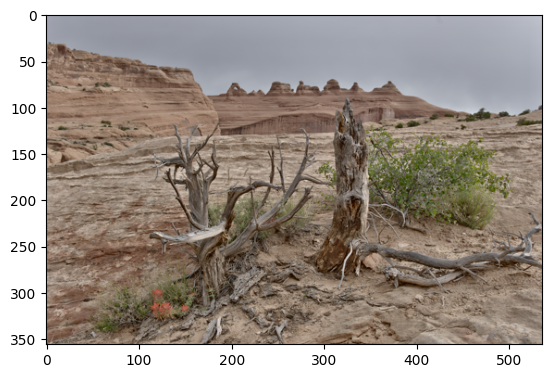

In [16]:
# 创建神经网络模型
model = CANNet()

criterion = Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # ADAM 优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_model(model=model, dataloader=dataloader, criterion=criterion, optimizer=optimizer, num_epochs=500, device=device)